# NLPD

In [1]:
!pip install https://github.com/google-research/perceptual-quality/archive/master.zip
from perceptual_quality import nlpd

  Using cached https://github.com/google-research/perceptual-quality/archive/master.zip
  Preparing metadata (setup.py) ... done


# import libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from IPython.display import display
import torchaudio
import torch
import torchaudio.transforms as T

# Audio

In [3]:
audio_path = 'ori0.wav'
samples, sample_rate = torchaudio.load(audio_path)
re48 = torchaudio.transforms.Resample(orig_freq=48000,new_freq=16000)
audio = re48(samples).mean(axis=0)

print(audio.shape)

window_size = 1024
hop_size = 260
num_mels = 256
reduced_sample_rate = 16000

transform = torchaudio.transforms.MelSpectrogram(n_mels=num_mels,
            n_fft=window_size,
            win_length=window_size,
            hop_length=hop_size,
            power=1,
            center=False,
            sample_rate=reduced_sample_rate,
            f_min=0,
            f_max=reduced_sample_rate / 2,
            window_fn=torch.hann_window,
            mel_scale='htk',
            norm=None)

mel_spec = transform(audio)

print(mel_spec.shape)

torch.Size([67328])
torch.Size([256, 256])


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


In [4]:
# mel_spec_mono = mel_spec.mean(axis=0)
# mel_spec_mono.shape
print(mel_spec.min(),mel_spec.max())
mel_spec_mono = np.log(mel_spec+10e-3)

tensor(0.) tensor(104.8741)


In [5]:
Max = mel_spec_mono.max()
min = mel_spec_mono.min()
print(min,Max)

mel_spec_proc = (mel_spec_mono-min)/(Max-min)

MM = mel_spec_proc.max()
mm = mel_spec_proc.min()
print(mm,MM)


tensor(-4.6052) tensor(4.6529)
tensor(0.) tensor(1.)


In [6]:
plt.imshow(mel_spec_proc,origin='lower')

In [7]:
x_np = np.reshape(mel_spec_proc,(1,1,mel_spec_proc.shape[0],mel_spec_proc.shape[1]))
x_np.shape

torch.Size([1, 1, 256, 256])

## Optimize the spectogram

In [43]:
# Generate restricted image

min_audio = 0 # min
Max_audio = 0.5 # max

################
x_np_aux2 = np.float32(x_np)
x_np_aux2_noise = np.float32(np.clip(x_np_aux2,min_audio,Max_audio))
Im_noisy_ori = np.transpose(x_np_aux2_noise[0], (1, 2, 0))

#

lr = 500000
N = 1500

ppp_noisy_up = np.zeros((N,))
mmm_noisy_up = np.zeros((N,))
nnn_noisy_up = np.zeros((N,))
uuu_noisy_up = np.zeros((N,))
sss_noisy_up = np.zeros((N,))

for ii in range(N):

    tf.config.run_functions_eagerly(True)

    A = tf.convert_to_tensor(np.transpose(x_np_aux2[0]*255, (1, 2, 0)))
    B = tf.convert_to_tensor(np.transpose(x_np_aux2_noise[0]*255, (1, 2, 0)))

    B_aux = np.transpose(x_np_aux2_noise[0]*255, (1, 2, 0))

    with tf.GradientTape() as tape:
        tape.watch(B)
        y_hat = tf.reduce_mean(nlpd.nlpd(A, B, 3))

    grads = tape.gradient(y_hat, B)

    B_aux2 = B_aux - lr * grads.numpy()

    B_aux3 = (B_aux2/255)

    x_np_aux2_noise[0] = np.transpose(np.float32(np.clip(B_aux3,0,1)), (2, 0, 1))

    # Impose restrictions

    x_np_aux2_noise = np.float32(np.clip(x_np_aux2_noise,min_audio,Max_audio))

    # Calculs

    nnn_noisy_up[ii] = np.mean(nlpd.nlpd(tf.convert_to_tensor(np.transpose((x_np_aux2[0])*255, (1, 2, 0))), tf.convert_to_tensor(np.transpose((x_np_aux2_noise[0])*255, (1, 2, 0))),3))

    print(y_hat.numpy(),ii,np.round(nnn_noisy_up[ii],5))

Im_noisy_opt_nlpd = np.transpose(x_np_aux2_noise[0], (1, 2, 0))

0.32696673 0 0.32133
0.32132608 1 0.31611
0.31610867 2 0.31127
0.31127357 3 0.30677
0.30677065 4 0.30256
0.30255777 5 0.2986
0.29860118 6 0.29487
0.29487273 7 0.29135
0.29134667 8 0.288
0.28800294 9 0.28482
0.28482333 10 0.28179
0.28179258 11 0.2789
0.27889797 12 0.27613
0.27612862 13 0.27347
0.27347362 14 0.27092
0.27092466 15 0.26847
0.26847398 16 0.26611
0.26611403 17 0.26384
0.26384017 18 0.26165
0.26164553 19 0.25952
0.2595246 20 0.25747
0.25747344 21 0.25549
0.25548777 22 0.25356
0.25356445 23 0.2517
0.2516992 24 0.24989
0.24988967 25 0.24813
0.24813282 26 0.24643
0.24642636 27 0.24477
0.24476719 28 0.24315
0.2431534 29 0.24158
0.24158187 30 0.24005
0.24005124 31 0.23856
0.23855937 32 0.2371
0.23710476 33 0.23569
0.23568538 34 0.2343
0.2343 35 0.23295
0.23294675 36 0.23162
0.2316245 37 0.23033
0.23033194 38 0.22907
0.22906852 39 0.22783
0.22783174 40 0.22662
0.22662167 41 0.22544
0.22543721 42 0.22428
0.22427765 43 0.22314
0.22314113 44 0.22203
0.22202812 45 0.22094
0.22093718 46

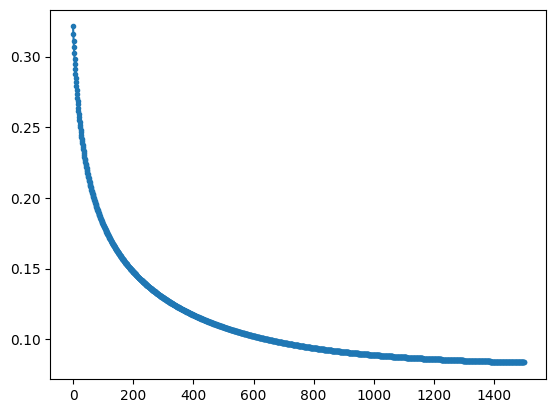

In [44]:
plt.plot(nnn_noisy_up,'.-')

<ipython-input-45-ded01c2d4c3b>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


(-0.5, 255.5, -0.5, 255.5)

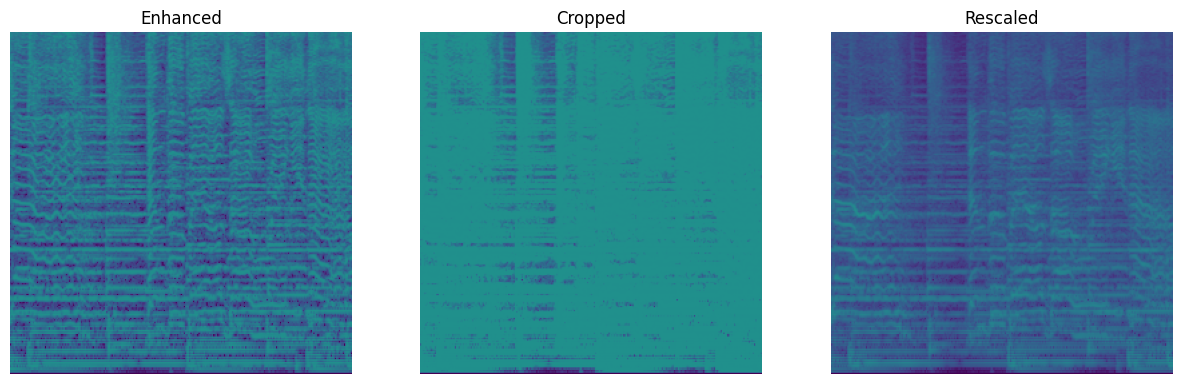

In [45]:
plt.subplots(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(Im_noisy_opt_nlpd,vmin=0,vmax=1,origin='lower')
plt.title('Enhanced')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(Im_noisy_ori,vmin=0,vmax=1,origin='lower')
plt.title('Cropped')
plt.axis('off')
plt.subplot(1,3,3)

im_scaled = mel_spec_proc*(Max_audio-min_audio)+min_audio
plt.imshow(im_scaled,vmin=0,vmax=1,origin='lower')
plt.title('Rescaled')
plt.axis('off')

In [46]:
print(Im_noisy_opt_nlpd.min(),Im_noisy_opt_nlpd.max())
print(Im_noisy_ori.min(),Im_noisy_ori.max())
print(im_scaled.min(),im_scaled.max())

0.0 0.5
0.0 0.50480247
tensor(0.) tensor(0.5000)


## Playback

In [47]:
window_size = 1024
hop_size = 260
n_mels = 256
reduced_sample_rate = 16000
size = 256

griffinlim = T.GriffinLim(n_fft=window_size,hop_length=hop_size,power=1,n_iter=500)
invmel = T.InverseMelScale(n_stft=(window_size//2)+1, n_mels=size, sample_rate=reduced_sample_rate, driver='gelsd')

ma = float(Max)
mi = float(min)
print(ma,mi)

4.65285587310791 -4.605170249938965


### Original Audio

In [48]:
### No mel spectrogram conversion

print(audio.min(),audio.max())
display(Audio(audio,rate=16000))

tensor(-1.0108) tensor(1.0024)


### Reconstructed Audio

tensor(0.) tensor(1.)


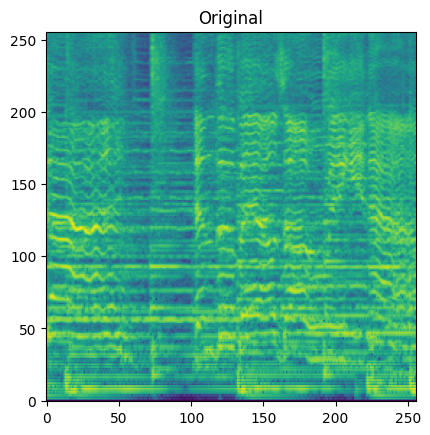

tensor(0.0090) tensor(104.8831)
tensor(0.) tensor(124.5444)
tensor(-1.4979) tensor(1.2214)


In [49]:
### Converting to mel spectrogram and back to audio without enhancement

aux = mel_spec_proc
aux = (aux-aux.min())/(aux.max()-aux.min())
print(aux.min(),aux.max())
rescaled = (aux * (ma-mi)) + mi

plt.imshow(mel_spec_proc,vmin=0,vmax=1,origin='lower')
plt.title('Original')
plt.show()

rescaled = torch.exp(rescaled) - 1e-3
print(rescaled.min(),rescaled.max())

melscaled = invmel(rescaled)
print(melscaled.min(),melscaled.max())

original_reconstructed = griffinlim(melscaled)
print(original_reconstructed.min(),original_reconstructed.max())

display(Audio(original_reconstructed,rate=16000))

### Enhanced Audio

0.0 0.5


<ipython-input-50-c206c5b8f904>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


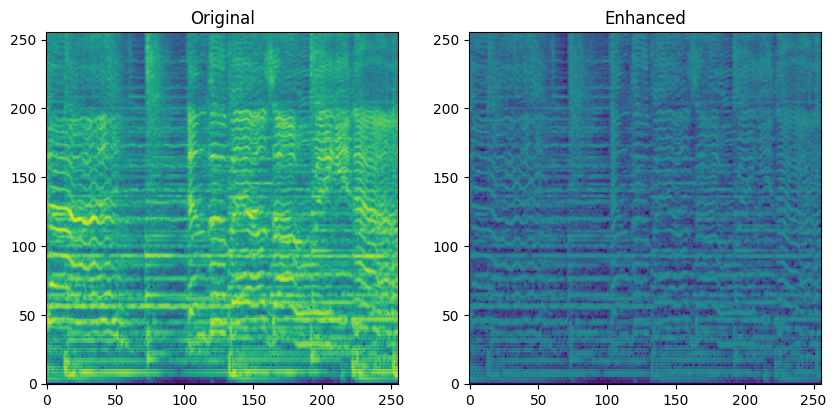

tensor(0.0090) tensor(1.0231)
tensor(0.) tensor(2.0272)
tensor(-0.0736) tensor(0.0712)


In [50]:
### Keeping in range 0.35-0.65

aux = Im_noisy_opt_nlpd.squeeze(-1)
print(aux.min(),aux.max())

plt.subplots(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(mel_spec_proc,vmin=0,vmax=1,origin='lower')
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(aux,vmin=0,vmax=1,origin='lower')
plt.title('Enhanced')
plt.show()

rescaled = torch.from_numpy((aux * (ma-mi)) + mi)

rescaled = torch.exp(rescaled) - 1e-3
print(rescaled.min(),rescaled.max())

melscaled = invmel(rescaled)
print(melscaled.min(),melscaled.max())

Im_noisy_opt_nlpd_rec = griffinlim(melscaled)
print(Im_noisy_opt_nlpd_rec.min(),Im_noisy_opt_nlpd_rec.max())

display(Audio(Im_noisy_opt_nlpd_rec,rate=16000))

### Reconstructed Sliced

0.0 0.50480247


<ipython-input-51-d257692def6c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


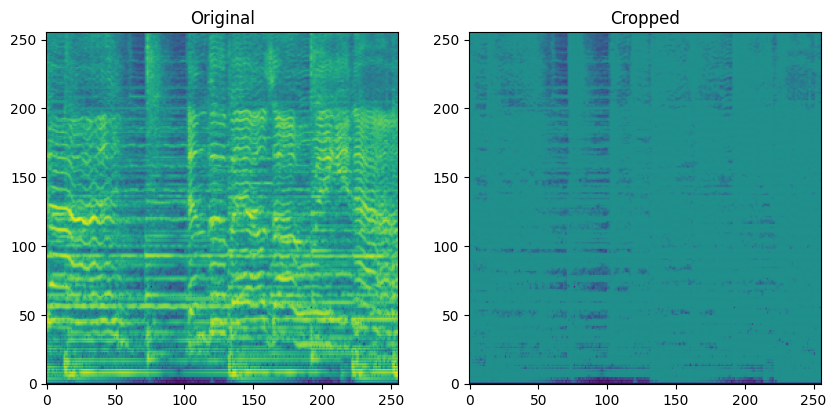

tensor(0.0090) tensor(1.0697)
tensor(0.) tensor(2.0765)
tensor(-0.1216) tensor(0.1521)


In [51]:
aux = Im_noisy_ori.squeeze(-1)
print(aux.min(),aux.max())

plt.subplots(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(mel_spec_proc,vmin=0,vmax=1,origin='lower')
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(aux,vmin=0,vmax=1,origin='lower')
plt.title('Cropped')
plt.show()

rescaled = torch.from_numpy((aux * (ma-mi)) + mi)

rescaled = torch.exp(rescaled) - 1e-3
print(rescaled.min(),rescaled.max())

melscaled = invmel(rescaled)
print(melscaled.min(),melscaled.max())

Im_noisy_opt_nlpd_rec = griffinlim(melscaled)
print(Im_noisy_opt_nlpd_rec.min(),Im_noisy_opt_nlpd_rec.max())

display(Audio(Im_noisy_opt_nlpd_rec,rate=16000))

### Reconstructed Scaled

In [52]:
rescaled.dtype

torch.float32

tensor(0.) tensor(0.5000)


<ipython-input-53-ed47e1f0d563>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


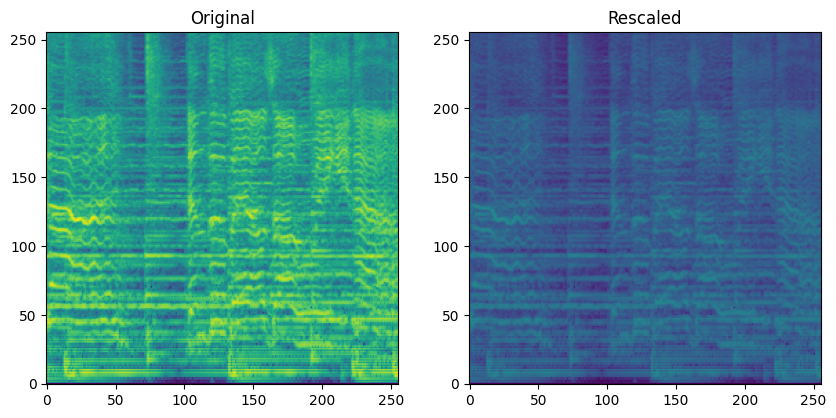

<ipython-input-53-ed47e1f0d563>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rescaled = torch.exp(torch.tensor(rescaled)) - 1e-3


tensor(0.0090) tensor(1.0231)
tensor(0.) tensor(1.4167)
tensor(-0.0324) tensor(0.0316)


In [53]:
aux = im_scaled
print(aux.min(),aux.max())

plt.subplots(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(mel_spec_proc,vmin=0,vmax=1,origin='lower')
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(aux,vmin=0,vmax=1,origin='lower')
plt.title('Rescaled')
plt.show()

rescaled = (aux * (ma-mi)) + mi

rescaled = torch.exp(torch.tensor(rescaled)) - 1e-3
print(rescaled.min(),rescaled.max())

melscaled = invmel(rescaled)
print(melscaled.min(),melscaled.max())

Im_noisy_opt_nlpd_rec = griffinlim(melscaled)
print(Im_noisy_opt_nlpd_rec.min(),Im_noisy_opt_nlpd_rec.max())

display(Audio(Im_noisy_opt_nlpd_rec,rate=16000))

### Enhanced & Rescaled

0.0 0.5
tensor(0.) tensor(1.)


<ipython-input-54-87b3e2bb1e61>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


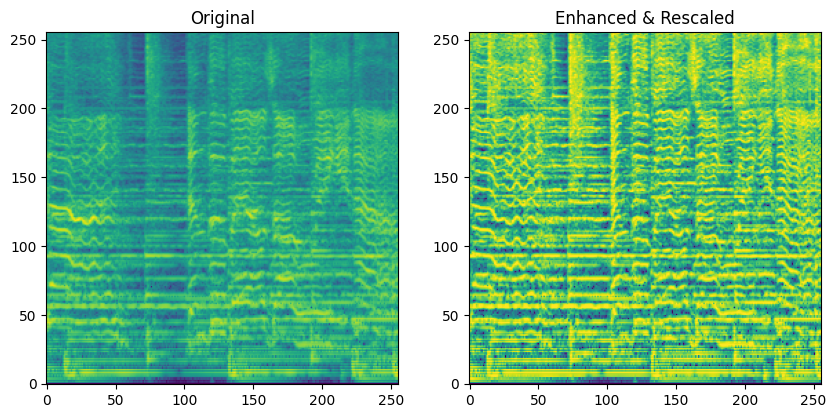

tensor(0.0090) tensor(104.8831)
tensor(0.) tensor(207.8169)
tensor(-5.6615) tensor(6.3966)


In [54]:
### Rescaling from 0.35-0.65 to 0-1

aux = Im_noisy_opt_nlpd.squeeze(-1)
print(aux.min(),aux.max())

aux = torch.from_numpy((aux-aux.min())/(aux.max()-aux.min()))
print(aux.min(),aux.max())

plt.subplots(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(mel_spec_proc,vmin=0,vmax=1,origin='lower')
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(aux,vmin=0,vmax=1,origin='lower')
plt.title('Enhanced & Rescaled')
plt.show()

rescaled = (aux * (ma-mi)) + mi

rescaled = torch.exp(rescaled) - 1e-3
print(rescaled.min(),rescaled.max())

melscaled = invmel(rescaled)
print(melscaled.min(),melscaled.max())

Im_noisy_opt_nlpd_rec = griffinlim(melscaled)
print(Im_noisy_opt_nlpd_rec.min(),Im_noisy_opt_nlpd_rec.max())

display(Audio(Im_noisy_opt_nlpd_rec,rate=16000))